In [1]:
cd ../TileEM/

/srv/data/home/jlee782/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from paper_visualizations import * 
from PixelEM import * 
from test_sample import test_sample_obj
import json
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Area weighted model 

$$ Qj = \frac{\sum_j  a(tj)*\delta_{ij}}{\sum_j  a(t_j)}$$ 

In [3]:
def aw_worker_prob_correct(mega_mask,w_mask, gt_mask,area_lst,Nworkers,exclude_isovote=False):
    if exclude_isovote:
        num_agreement= len(np.where((mega_mask==0) | (mega_mask==Nworkers))[0]) # no votes
    else:
        num_agreement = 0
#     print "Num agreement:", num_agreement
    numerator = 0
    #denominator = np.sqrt(area_mask.sum())
    denominator = sum(area_lst)
    for i in range(np.shape(gt_mask)[0]):
        for j in range(np.shape(gt_mask)[1]):
            gt = gt_mask[i][j]
            w  = w_mask[i][j]
            m = mega_mask[i][j]
            if exclude_isovote:
                not_agreement=False
            else:
                not_agreement=True
            if m!=0 and  m!=Nworkers:
                not_agreement=True
                
            if not_agreement:
                if ((gt==1) and (w==1)) or  (gt==0 and w==0): #correct
                    numerator+= 1
#     print numerator
#     print denominator
#     print numerator
#     print denominator-num_agreement
    qj = float(numerator)/(denominator-num_agreement)
    return qj

In [5]:
# aw_worker_prob_correct(mega_mask,worker_masks[wid], gt_est_mask,area_mask,Nworkers,exclude_isovote=True)

# aw_worker_prob_correct(mega_mask,worker_masks[wid], gt_est_mask,area_mask,Nworkers,exclude_isovote=False)

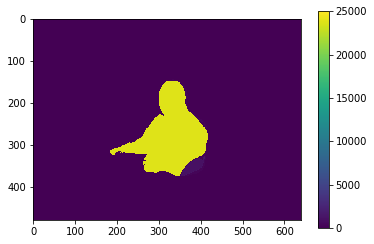

In [27]:
plt.imshow(area_mask)
plt.colorbar()

In [8]:
def do_Area_EM_for(sample_name, objid, num_iterations=5,load_p_in_mask=False,thresh=0,rerun_existing=False,exclude_isovote=False,dump_output_at_every_iter=False,debug=False):
    print "Doing EM"
    outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
    if exclude_isovote:
        mode ='iso'
    else:
        mode =''
    if rerun_existing:
        if os.path.isfile('{}AW_EM_prj_thresh{}.json'.format(outdir,thresh)):
            print "Already ran, Skipped"
            return

    # initialize MV mask
    gt_est_mask = get_MV_mask(sample_name, objid)
    worker_masks = get_all_worker_mega_masks_for_sample(sample_name, objid)
    area_lst = pkl.load(open("{}/tarea.pkl".format(outdir)))
    #area_mask = pkl.load(open("{}/tarea_mask.pkl".format(outdir)))
    tidx_mask = pkl.load(open("{}/tidx_mask.pkl".format(outdir)))

    Nworkers= len(worker_masks)
    mega_mask = get_mega_mask(sample_name, objid)
    for it in range(num_iterations):
        if debug: print "iter #",it
        worker_qualities = dict()
        for wid in worker_masks.keys():
            worker_qualities[wid] = aw_worker_prob_correct(mega_mask,worker_masks[wid], gt_est_mask,area_lst,Nworkers,exclude_isovote=exclude_isovote)
        if load_p_in_mask:
            #print "loaded pInT"
            log_probability_in_mask=pkl.load(open('{}{}p_in_mask_{}.pkl'.format(outdir,mode, it)))
            log_probability_not_in_mask =pkl.load(open('{}{}p_not_in_mask_{}.pkl'.format(outdir,mode, it)))
        else:
            #Compute pInMask and pNotInMask
            log_probability_in_mask, log_probability_not_in_mask = mask_log_probabilities(worker_masks, worker_qualities)
            with open('{}{}p_in_mask_{}.pkl'.format(outdir, mode,it), 'w') as fp:
                fp.write(pickle.dumps(log_probability_in_mask))
            with open('{}{}p_not_in_mask_{}.pkl'.format(outdir,mode, it), 'w') as fp:
                fp.write(pickle.dumps(log_probability_not_in_mask))
        gt_est_mask = estimate_gt_from(log_probability_in_mask, log_probability_not_in_mask,thresh=thresh)
        if debug : 
            plt.figure()
            plt.imshow(gt_est_mask, interpolation="none")  # ,cmap="rainbow")
            plt.colorbar()
            # plt.savefig('{}{}AW_EM_mask_thresh{}.png'.format(outdir,mode,thresh))
        
        
        # Compute PR mask based on the EM estimate mask from every iteration
        [p, r, j] = faster_compute_prj(gt_est_mask, get_gt_mask(objid))
        with open('{}{}AW_EM_prj_iter{}_thresh{}.json'.format(outdir,mode,it,thresh), 'w') as fp:
            fp.write(json.dumps([p, r, j]))
        if debug : print p,r,j
        if dump_output_at_every_iter:
            pickle.dump(gt_est_mask,open('{}{}AW_gt_est_mask_{}_thresh{}.pkl'.format(outdir,mode,it,thresh), 'w'))
            pickle.dump(log_probability_in_mask,open('{}{}AW_p_in_mask_{}_thresh{}.pkl'.format(outdir,mode,it,thresh), 'w'))
            pickle.dump(log_probability_not_in_mask,open('{}{}AW_p_not_in_mask_{}_thresh{}.pkl'.format(outdir,mode, it,thresh), 'w'))
            pickle.dump(worker_qualities,open('{}{}AW_qj_{}_thresh{}.pkl'.format(outdir,mode, it,thresh), 'w'))

    pickle.dump(gt_est_mask,open('{}{}AW_gt_est_mask_{}_thresh{}.pkl'.format(outdir,mode,it,thresh), 'w'))
    pickle.dump(log_probability_in_mask,open('{}{}AW_p_in_mask_{}_thresh{}.pkl'.format(outdir,mode,it,thresh), 'w'))
    pickle.dump(log_probability_not_in_mask,open('{}{}AW_p_not_in_mask_{}_thresh{}.pkl'.format(outdir,mode, it,thresh), 'w'))
    pickle.dump(worker_qualities,open('{}{}AW_qj_{}_thresh{}.pkl'.format(outdir,mode, it,thresh), 'w'))

    

Doing EM
iter # 0
0.778265412748 0.983104540655 0.767993400701
iter # 1
0.778265412748 0.983104540655 0.767993400701
iter # 2
0.778265412748 0.983104540655 0.767993400701
iter # 3
0.778265412748 0.983104540655 0.767993400701
iter # 4
0.778265412748 0.983104540655 0.767993400701


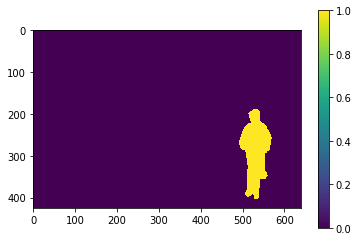

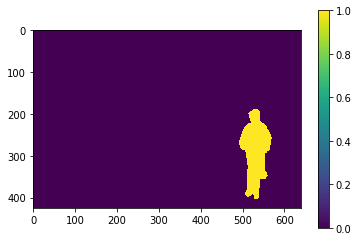

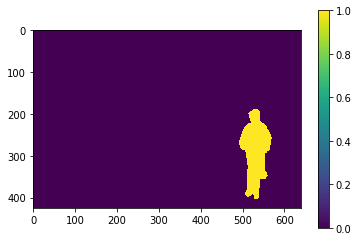

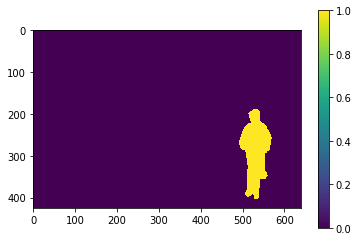

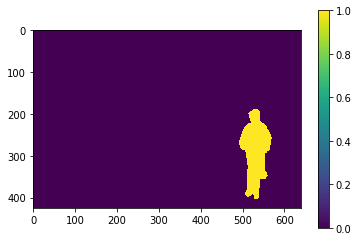

In [9]:
sample_name ='5workers_rand0'
objid=37
do_Area_EM_for(sample_name, objid, num_iterations=5,load_p_in_mask=False,thresh=0,rerun_existing=False,exclude_isovote=False,dump_output_at_every_iter=False,debug=True)

Doing EM
iter # 0
0.707965441944 0.98429250264 0.70005632745
iter # 1
0.00226483068412 0.0793294614572 0.00220682463272
iter # 2
0.00226483068412 0.0793294614572 0.00220682463272
iter # 3
0.00226483068412 0.0793294614572 0.00220682463272
iter # 4
0.00226483068412 0.0793294614572 0.00220682463272


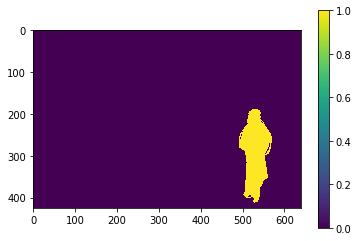

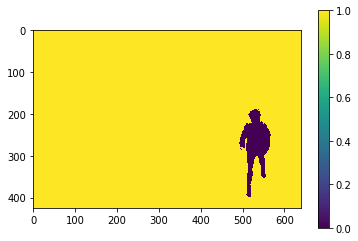

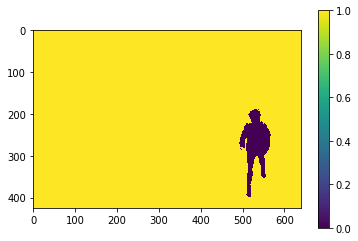

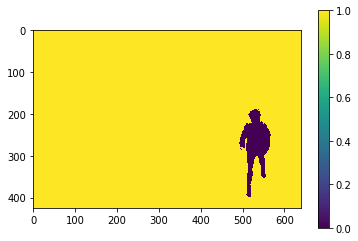

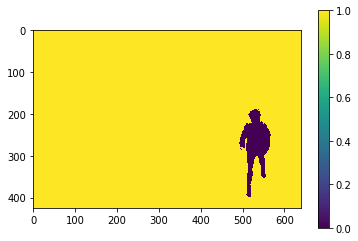

In [12]:
sample_name ='5workers_rand0'
objid=37
do_Area_EM_for(sample_name, objid, num_iterations=5,load_p_in_mask=False,thresh=0,rerun_existing=False,exclude_isovote=True,dump_output_at_every_iter=False,debug=True)

Doing EM
iter # 0
0.986084598999 0.974652046704 0.961428494363
iter # 1
0.986084598999 0.974652046704 0.961428494363
iter # 2
0.986084598999 0.974652046704 0.961428494363
iter # 3
0.986084598999 0.974652046704 0.961428494363
iter # 4
0.986084598999 0.974652046704 0.961428494363


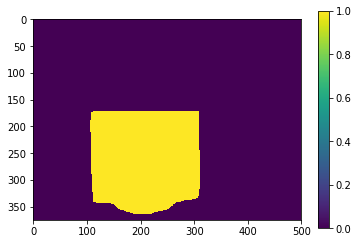

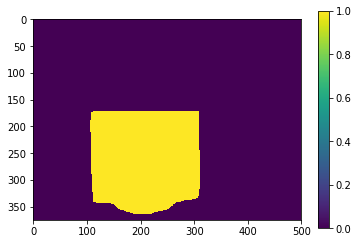

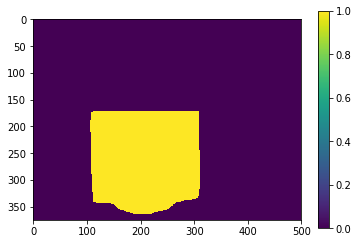

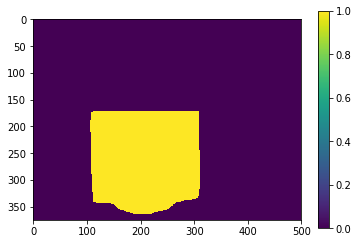

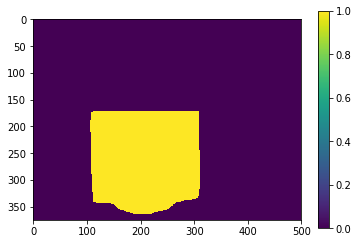

In [13]:
sample_name ='5workers_rand0'
objid=18
do_Area_EM_for(sample_name, objid, num_iterations=5,load_p_in_mask=False,thresh=0,rerun_existing=False,exclude_isovote=False,dump_output_at_every_iter=False,debug=True)

Doing EM
iter # 0
0.987101417183 0.975144239972 0.962874962875
iter # 1
0.987101417183 0.975144239972 0.962874962875
iter # 2
0.987101417183 0.975144239972 0.962874962875
iter # 3
0.987101417183 0.975144239972 0.962874962875
iter # 4
0.987101417183 0.975144239972 0.962874962875


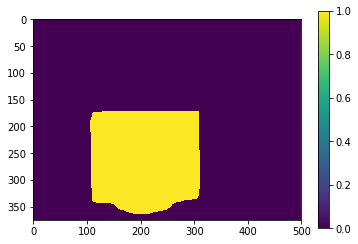

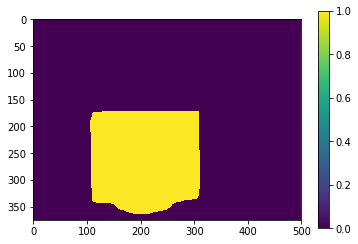

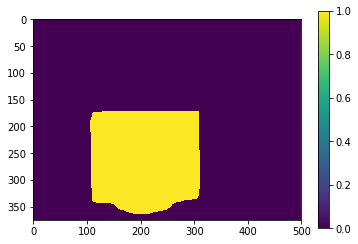

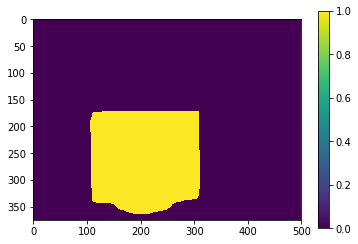

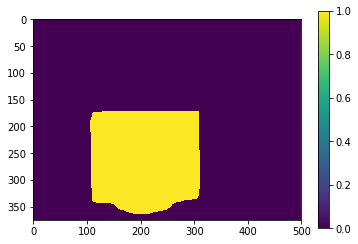

In [15]:
sample_name ='5workers_rand0'
objid=18
do_Area_EM_for(sample_name, objid, num_iterations=5,load_p_in_mask=False,thresh=0,rerun_existing=False,exclude_isovote=True,dump_output_at_every_iter=False,debug=True)

In [16]:
worker  = pkl.load(open("uniqueTiles/25workers_rand0/worker1.pkl"))

In [17]:
worker

[75,
 247,
 201,
 137,
 116,
 239,
 118,
 219,
 223,
 248,
 140,
 181,
 199,
 146,
 52,
 234,
 170,
 148,
 114,
 156,
 133,
 246,
 196,
 238,
 175]

In [18]:
computed_GT_info =  pd.read_csv("../computed_my_COCO_BBvals.csv",index_col=0)

In [28]:
objid=1
worker_id=199
GT_info_keys = ['Num Points','Area Ratio','Precision [Self]','Recall [Self]','Jaccard [Self]','TPR [Self]','FNR [Self]','TNR [Self]', 'FPR [Self]']
numPts,area_ratio, P,R,J,TPR,FNR,TNR,FPR = computed_GT_info[(computed_GT_info["object_id"]==objid)&(computed_GT_info["worker_id"]==worker_id)][GT_info_keys].values[0]

In [29]:
computed_GT_info[(computed_GT_info["object_id"]==objid)&(computed_GT_info["worker_id"]==worker_id)][GT_info_keys].values[0]

array([  5.60000000e+01,   8.82177734e-02,   9.41082688e-01,
         9.87677616e-01,   9.30161604e-01,   9.87677616e-01,
         6.18344285e-02,   9.94325467e-01,   5.67453252e-03])

In [27]:
worker_tbl= pd.read_csv("all_worker_response_info.csv")
worker_tbl[(worker_tbl["worker id"]==199)&(worker_tbl["objid"]==1)]

,Unnamed: 0,objid,worker id,Num Points,Area Ratio,P [GT],R [GT],J [GT],TPR [GT],FNR [GT],TNR [GT],FPR [GT]


In [30]:
len(worker_tbl)

1320